# Objective
The objective of this notebook is to predict RAR for MLB batters up to and including their age 30 season. Probabilistic programming will be accomplish this, and we will be using PyMC3 as the primary modelling library.

We will work to see how well the forecast values line up with reality. Our focus will be on prospects that were included in Baseball America's top 10 prospects at some point in their career. All data existing prior to the age 27 season of top prospects will be included in the model, as well as all other hitter seasons prior to age 30. Then we will forecast what we expect to see in the age 27 to 30 seasons for those top prospects, allowing us to see which players underperformed the most based on their early career performance. Bayesian modelling can establish a "true" skill level prior to age 27 that regresses toward the league average. Then we can make adjustments to that baseline skill later on to forecast older seasons. 

In [1]:
# Load required packages
import numpy as np
import pandas as pd
import seaborn as sns
import arviz as az
import pymc3 as pm
import theano.tensor as tt

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Configure graphics
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

# Preprocessing

We will need to merge a number of different data sources and calculate some statistics like defensive RAA, OBP, SLG.

In [3]:
# Read in data
appearances = pd.read_csv("Appearances.csv")
batting_df = pd.read_csv("Batting.csv")
people = pd.read_csv("People.csv")
rankings = pd.read_excel("historic_prospect_ranking_with_Lahman_ID.xlsx")

In [4]:
# Rename columns to match other tables
rankings.rename(columns={'year': 'yearID', 'lahman_id': 'playerID'}, inplace=True)

In [5]:
# Find the highest prospect ranking each player achieved
max_rankings = rankings[['playerID','prospect_rank']].groupby('playerID', as_index=False).min()
max_rankings.columns= ['playerID','max_rank']
# Merge prospect ranking with batting data
batting_temp = batting_df.merge(rankings[['yearID','playerID','prospect_rank']], on=['yearID','playerID'],
                               how='left').merge(max_rankings, on='playerID',how='left')
# Create column that flags if a player was ever a top 100 prospect
batting_temp.loc[~batting_temp['max_rank'].isna(), 'prospect_flag'] = 'top_100'
batting_temp['prospect_flag'].fillna('out_100', inplace=True)


In [6]:
# Split data to only include years after 1994
batting = batting_temp.loc[batting_df['yearID']>=1994].reset_index(drop=True)

In [7]:
# Filter out pitchers by only including players that have more appearances as batters
app_group = appearances.groupby(['playerID'], as_index=False).sum()
app_batters = app_group.loc[(app_group['G_batting']>=app_group['G_p'])&(app_group['G_batting']>0)].reset_index(drop=True)
m = batting.playerID.isin(app_batters.playerID)
batting = batting[m]

In [8]:
# Calculate the positional value each batter brings each year
pos_cols = ['playerID','yearID','GS','G_c','G_1b','G_2b','G_3b','G_ss','G_lf','G_cf','G_rf','G_dh']
app_positions = appearances[pos_cols].groupby(['playerID','yearID'], as_index=False).sum()
app_positions['G_all'] = app_positions[pos_cols[3:]].sum(axis=1)
# Find defensive RAA and adjust it to scale per 150 games
app_positions['raa_c'] = app_positions['G_c']*(app_positions['GS']/app_positions['G_all'])*9.0/150.0
app_positions['raa_1b'] = app_positions['G_1b']*(app_positions['GS']/app_positions['G_all'])*-9.5/150.0
app_positions['raa_2b'] = app_positions['G_2b']*(app_positions['GS']/app_positions['G_all'])*3.0/150.0
app_positions['raa_3b'] = app_positions['G_3b']*(app_positions['GS']/app_positions['G_all'])*2.0/150.0 
app_positions['raa_ss'] = app_positions['G_ss']*(app_positions['GS']/app_positions['G_all'])*7.0/150.0 
app_positions['raa_lf'] = app_positions['G_lf']*(app_positions['GS']/app_positions['G_all'])*-7.0/150.0 
app_positions['raa_cf'] = app_positions['G_cf']*(app_positions['GS']/app_positions['G_all'])*2.5/150.0 
app_positions['raa_rf'] = app_positions['G_rf']*(app_positions['GS']/app_positions['G_all'])*-7.0/150.0 
app_positions['raa_dh'] = app_positions['G_dh']*(app_positions['GS']/app_positions['G_all'])*-15.0/150.0 

# Add it all up to find total RAA
app_idx = app_positions.columns.str.startswith('raa')
app_positions['raa_total'] = app_positions.iloc[:,app_idx].sum(axis=1)

In [9]:
# Create new columns for some useful statistics
batting['PA'] = batting['AB']+batting['BB']+batting['HBP']+batting['SH']+batting['SF']
batting['OBP_num'] = batting['H']+batting['BB']+batting['HBP']
batting['OBP_denom'] = batting['AB']+batting['BB']+batting['HBP']+batting['SF']
batting['1B'] = batting['H']-batting['2B']-batting['3B']-batting['HR']
batting['outs'] = batting['AB']-batting['H']

In [13]:
# Functions to make it easier to find OBP and SLG
def SLG_finder(x):
    SLG = ((x['H']-x['2B']-x['3B']-x['HR'])
        +2*x['2B']+3*x['3B']+4*x['HR']).sum() \
        /x['AB'].sum()
    return SLG
        
def OBP_finder(x):    
    OBP = (x['H']+x['BB']+x['HBP']).sum() \
         /(x['AB']+x['BB']+x['HBP']+x['SF']).sum()
    return OBP

In [14]:
# Average American League SLG each year
avg_SLG = pd.DataFrame(batting.loc[batting['lgID'] == 'AL'].groupby('yearID', as_index=False).apply(SLG_finder))
avg_SLG.columns = ['yearID', 'avg_SLG']

In [15]:
# Average American League OBP each year
avg_OBP = pd.DataFrame(batting.loc[batting['lgID'] == 'AL'].groupby('yearID', as_index=False).apply(OBP_finder))
avg_OBP.columns = ['yearID', 'avg_OBP']

In [16]:
# Merge some dataframes together
batting_final = batting.merge(avg_SLG, on = 'yearID').merge(avg_OBP, on = 'yearID') \
    .merge(people[['playerID','birthYear','birthMonth','birthDay']], on='playerID') 

In [17]:
# League average OPS each year for each batter
batting_final['avg_OPS'] = batting_final['avg_SLG']+batting_final['avg_OBP']

In [18]:
# A function to find each batter's age in each season;
# Batters born before July 1 are rounded up to the next age for that season
from datetime import date, datetime

def age_finder(x):
    year_date = datetime(int(x['yearID']),7,1)
    birthdate = datetime(int(x['birthYear']),int(x['birthMonth']),int(x['birthDay']))
    return year_date.year - birthdate.year - ((year_date.month, year_date.day) < (birthdate.month, birthdate.day))

In [19]:
# Find age and merge it all together
batting_final['age'] = batting_final.apply(lambda x: age_finder(x),axis=1)
apps = app_positions.merge(batting_final[['playerID','yearID','age','avg_OPS','prospect_flag']], on = ['playerID', 'yearID']) \
    .merge(rankings[['playerID','yearID']], on = ['playerID', 'yearID'], how='left') \
    .merge(max_rankings, on='playerID', how='left')

In [20]:
# We'll create a list of multipliers for OBP and SLG as part of the aging curve
avg_age_OBP = pd.DataFrame(batting_final.loc[batting_final['age'] <= 30].groupby('age', as_index=False).apply(OBP_finder))
avg_age_OBP.columns = ['age','OBP']
avg_age_SLG = pd.DataFrame(batting_final.loc[batting_final['age'] <= 30].groupby('age', as_index=False).apply(SLG_finder))
avg_age_SLG.columns = ['age','SLG']

In [21]:
# Prepare dataframes for Bayesian models
def df_prepper(df):
    pa_history = df.loc[df['age']<=30][['playerID','yearID','PA']].groupby(['playerID','yearID'], as_index=False).sum() \
        .merge(apps[['playerID','yearID','age','raa_total','prospect_flag','avg_OPS']], on = ['playerID', 'yearID'])
    OBP_totals = df.loc[df['age']<=30][['playerID','prospect_flag','OBP_num','OBP_denom']] \
        .groupby(['playerID','prospect_flag'], as_index=False).sum()
    SLG_totals = df.loc[df['age']<=30][['playerID','1B', '2B', '3B', 'HR', 'outs', 'AB']] \
        .groupby(['playerID'], as_index=False).sum()
    return pa_history, OBP_totals, SLG_totals

In [22]:
# Find all batters with at bats before or during age 26 season that were also top ten prospects;
# We need this later to compare model predictions with reality
top_ten = batting_final.loc[(batting_final['max_rank']<=10)&(batting_final['age']<=26)].reset_index(drop=True)
top_ten_pros = list(top_ten['playerID'].unique())
# Scrub out later seasons from data so it isn't included in model fitting
batting_all = batting_final.loc[~(batting_final.playerID.isin(top_ten_pros)&(batting_final['age']>26))]
# Dataframe of 27 and older seasons for top ten prospects
batting_older = batting_final.loc[(batting_final.playerID.isin(top_ten_pros)&(batting_final['age']>26))]

In [23]:
# Add OBP and SLG data to older years
def_older = batting_older.loc[batting_older['age']<=30][['playerID','yearID','age','PA']] \
                  .groupby(['playerID','yearID','age'], as_index=False).sum() \
                  .merge(apps[['playerID','yearID','raa_total']],on=['playerID','yearID'], how='left')
OBP_older = batting_older.loc[batting_older['age']<=30].groupby(['playerID','yearID'], as_index=False).apply(OBP_finder)
OBP_older.columns = ['playerID','yearID','OBP']
SLG_older = batting_older.loc[batting_older['age']<=30].groupby(['playerID','yearID'], as_index=False).apply(SLG_finder)
SLG_older.columns = ['playerID','yearID','SLG']
     
    
older = def_older.merge(OBP_older[['playerID','yearID','OBP']], on = ['playerID','yearID']) \
        .merge(SLG_older[['playerID','yearID','SLG']], on = ['playerID','yearID'])

older['OPS'] = older['OBP']+older['SLG']

In [24]:
# Data to be used in Bayesian models
pa_batter, OBP_totals_bat, SLG_totals_bat  = df_prepper(batting_all)

In [25]:
# Average PA at each age
avg_age_PA = pd.DataFrame(pa_batter.groupby('age', as_index=False).mean('PA'))

In [26]:
# Average OBP and SLG across all ages 18 to 30
avg_total_OBP = OBP_totals_bat['OBP_num'].sum()/OBP_totals_bat['OBP_denom'].sum()
avg_total_SLG = (SLG_totals_bat['1B'].sum()+2*SLG_totals_bat['2B'].sum() \
                 +3*SLG_totals_bat['3B'].sum()+4*SLG_totals_bat['HR'].sum()) \
                 /SLG_totals_bat['AB'].sum()

# Average PA at each season
avg_PA = avg_age_PA['PA'].mean()

In [27]:
# Scaled values compared to average
scaled_OBP = avg_age_OBP/avg_total_OBP
scaled_SLG = avg_age_SLG/avg_total_SLG
scaled_PA = avg_age_PA[['age','PA']]/avg_PA


In [28]:
scales = pd.concat([avg_age_OBP['age'], scaled_OBP['OBP'], scaled_SLG['SLG'], 
                    scaled_PA['PA']], axis=1)

In [29]:
#Scaling multiplier based on age
scales

,age,OBP,SLG,PA
0,18,0.727430,0.481819,0.273933
1,19,0.943435,0.988396,0.750497
2,20,1.012743,1.020050,0.925046
3,21,0.981616,0.969468,0.767632
4,22,0.980807,0.986414,0.906759
5,23,0.973956,0.981112,0.910350
6,24,0.983152,0.981610,0.961712
7,25,0.990399,0.993832,1.048767
8,26,1.003419,1.006789,1.151311
9,27,1.002294,1.009007,1.210563


# Bayesian Model
My approach to modelling is to establish a baseline level of skill for each batter and then make any necessary adjustments. That means using Bayesian modelling to estimate PA, defensive RAA, OBP, and SLG skills, then make any adjustments later based on age or other factors. For all hitters, except the elite prospects we're looking to make predictions for, the data consists of every season up to and including their age 30 season. The elite prospects have their age 27 to 30 seasons scrubbed from the model fitting process. More on that later.

Bayesian modelling is hugely advantageous when it comes to estimating skill levels for players without much major league data available. We can combine their brief history with the tendencies of the league to get a fair representation of their skill. 

The downside to this approach is the time it takes the model to sample and discover the distribution of each variable. I also believe there are better methods available if a hitter has an extended history in the majors where we can be confident of their skill level. For hitters that have only a handful of at-bats, however, I believe the Bayesian approach is superior. Since there are so many hitters that receive limited playing time, I've chosen to go in this direction.

In [30]:
# Dictionaries and lookups to be used in our models
all_batters = pa_batter.playerID.unique()
n_batters = len(all_batters)
batter_lookup = dict(zip(all_batters, range(n_batters)))
batteri = pa_batter['batter_idx'] = pa_batter.playerID.replace(batter_lookup).values

all_pros = OBP_totals_bat.prospect_flag.unique()
n_pros = len(all_pros)
pros_lookup = dict(zip(all_pros, range(n_pros)))
prosi = OBP_totals_bat['pros_idx'] = OBP_totals_bat.prospect_flag.replace(pros_lookup).values

In [31]:
# Counts for OBP and SLG models
OBP_num, OBP_denom = OBP_totals_bat[["OBP_num", "OBP_denom"]].to_numpy().T
SLG_counts, SLG_AB = SLG_totals_bat[['1B', '2B', '3B', 'HR', 'outs']].to_numpy(), SLG_totals_bat[['AB']].to_numpy().T

# PA and Defensive RAA Model
To calculate PA in each season, we will use a Poisson model to find the rate of PA per season. Of course, some batters accumulate more PA per season, but there are many factors that go into playing time. A Poisson distribution gives a range of reasonable PA values we can expect to see as a baseline each season. Later on, a multiplier will help make an adjustment based on age; players in their late 20s tend to get more PA. 

To calculate defensive RAA in each season, we will use a Normal distribution to find the rate of defensive RAA per season for a given batter. This establishes a baseline, and as you recall we are later going to focus on prospects from age 27 to 30. We hope to get a sense of what their defensive skills are prior to those seasons. A player's defensive value may decline as they get older and we are not making a manual adjustment like we are for OBP, SLG, and PA, so the estimate of defensive RAA may overshoot on age 27 to 30 seasons.   

In [32]:
# Coordinates for PA and RAA model
coords = {'batters': batteri, 'prospect':prosi, 'obs_id': np.arange(batteri.size)}

In [33]:
with pm.Model(coords=coords) as PA_raa_model:
    batter_idx = pm.Data('batter_idx', batteri, dims='obs_id')

    # Poisson count for PA;
    # Uniform distribution is used as a hyperprior
    lambda_prior_PA = pm.Uniform('lambda_prior_PA', 0, 1000, shape = n_batters)
    # Likelihood for observed PA
    Y_obs_PA = pm.Poisson('Y_obs',mu=lambda_prior_PA[batter_idx], observed = pa_batter.PA)

    # Hyperpriors
    a = pm.Normal('a', mu=0.0,sigma=10.0)
    sigma_a = pm.Exponential('sigma_a',0.5)
    
    # Intercept of model
    a_batter = pm.Normal('a_batter',mu=a,sigma=sigma_a, shape=n_batters)
    # Expected defensive RAA for each batter
    theta = a_batter[batter_idx]
    # Error of the model
    sigma = pm.Exponential('sigma',0.5)
    
    # Fit to observed values
    y = pm.Normal('y',theta,sigma=sigma,observed=pa_batter.raa_total, dims='obs_id')
    

In [34]:
# Draw 500 samples and tune on 500 more
with PA_raa_model:
    pp_trace = pm.sample(draws=500,tune=1000,target_accept=0.90, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, a_batter, sigma_a, a, lambda_prior_PA]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 818 seconds.


0, dim: obs_id, 11712 =? 11712


The acceptance probability does not match the target. It is 0.8156732874313489, but should be close to 0.9. Try to increase the number of tuning steps.


In [35]:
# Sample from posterior to store each batter's PA and defensive RAA baseline skill
ppc = pm.sample_posterior_predictive(
      trace=pp_trace,
      model=PA_raa_model,
      var_names=['lambda_prior_PA','a_batter'],
      progressbar=True)

The plots below show the PA and defensive RAA estimate "skill" levels for the first five batters in the batter_lookup dictionary as an example. There are a wide range of PA estimates based on the each batter's history. The defensive RAA values are huddled around 0. 

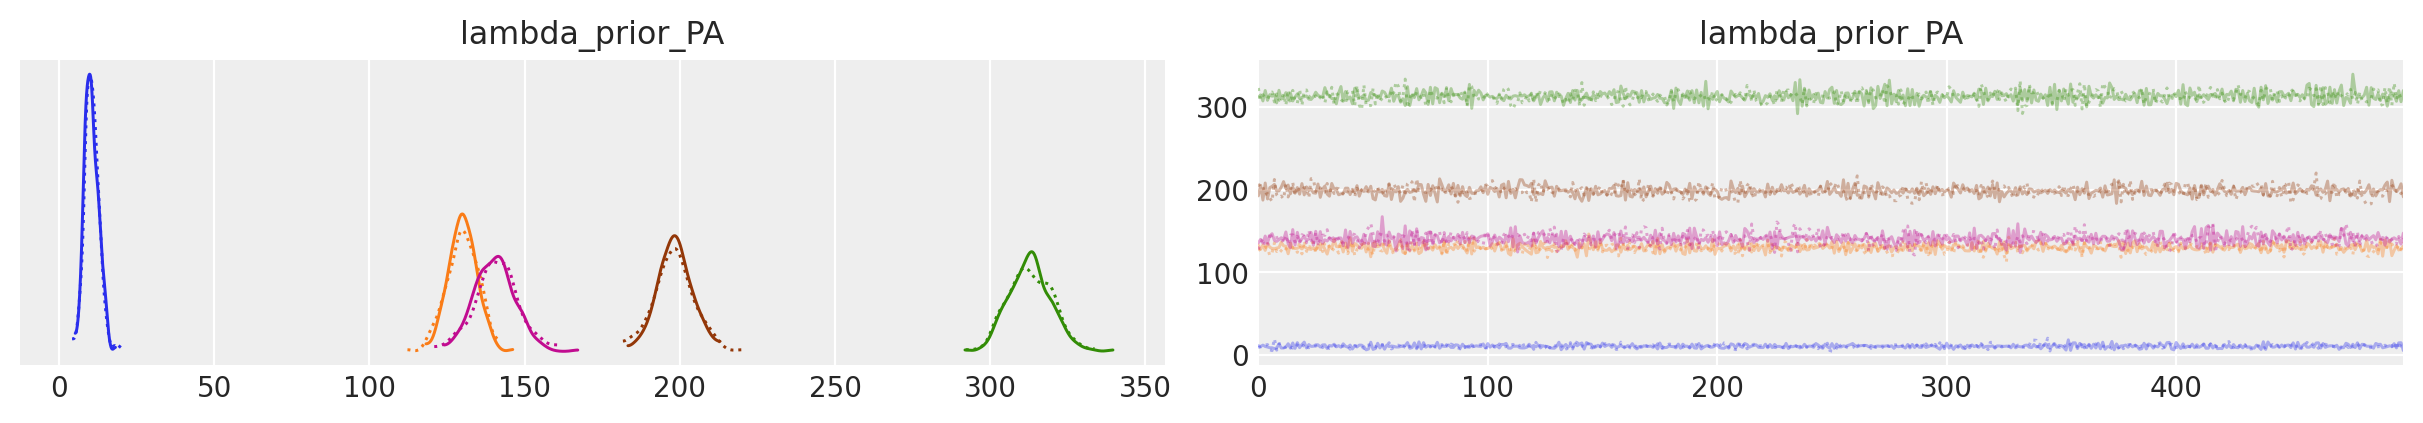

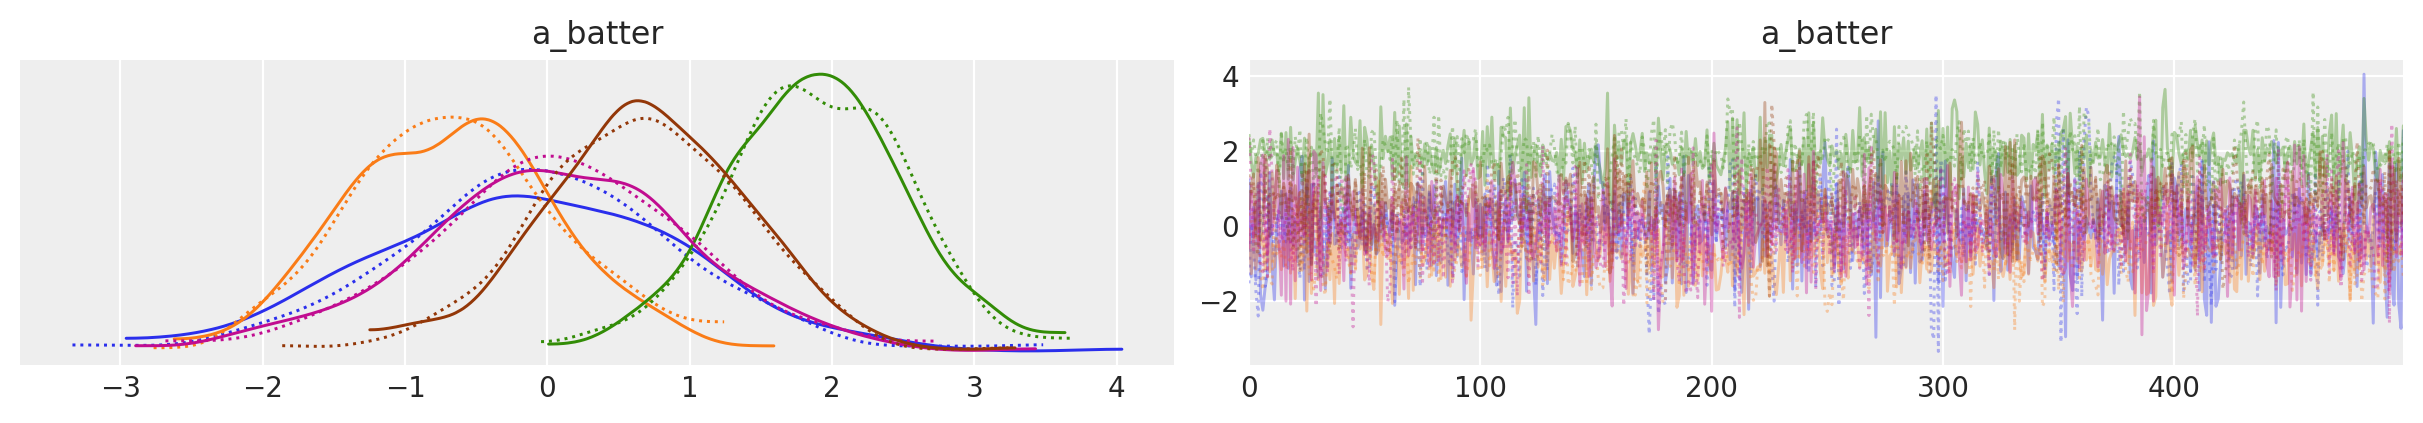

In [36]:
with PA_raa_model:
    az.plot_trace(pp_trace, var_names=['lambda_prior_PA'], coords ={'lambda_prior_PA_dim_0':range(5)})
    az.plot_trace(pp_trace, var_names=['a_batter'], coords ={'a_batter_dim_0':range(5)})

# OBP model
The OBP model takes a uniform hyperprior and uses it as part of a prior for a Beta distribution. The hyperprior can be thought of as "shared" skill among all the players. We'll use a partially pooled distribution model, so players with fewer plate appearances have their estimated OBP skill drawn back to the league average. We'll also introduce different levels based on prospect status. One group will be players that were top 100 prospects at some point, and the other will be players not highly regarded as prospects, or outside Baseball America's top 100 lists.  

In [37]:
coords_OBP = {'prospect':prosi, 'obs_id': np.arange(prosi.size)}

In [38]:
with pm.Model(coords=coords_OBP) as OBP_model:
    pros_idx = pm.Data('pros_idx', prosi, dims='obs_id')

    phi = pm.Uniform("phi", lower=0.0, upper=1.0, shape=n_pros)

    kappa_log = pm.Exponential("kappa_log", lam=1.75)
    kappa = pm.Deterministic("kappa", tt.exp(kappa_log))

    thetas = pm.Beta("thetas", alpha=phi[pros_idx] * kappa, beta=(1.0 - phi[pros_idx]) * kappa, shape=len(OBP_num))
    y = pm.Binomial("y", n=OBP_denom, p=thetas, observed=OBP_num)

In [39]:
with OBP_model:
    OBP_trace = pm.sample(draws=500,tune=500,target_accept=0.90, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [thetas, kappa_log, phi]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 753 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


In [40]:
# Store each batter's OBP skill
OBP_pp = pm.sample_posterior_predictive(
      trace=OBP_trace,
      model=OBP_model,
      var_names=['thetas'],
      progressbar=True)

The graph below shows the hyperprior values for top 100 prospects versus players outside the top 100. The orange curve shows the top 100 group, suggesting they have a higher base level of skill when it comes to OBP. Again, top 10 prospect seasons over the age of 26 are not included.  

There is also a plot of the estimated skill of Bobby Abreu below. He is hitter number 5 in the batter_lookup dictionary, and we can see that before age 27 we would estimate his OBP skill to be close to .400. 

In [41]:
batter_lookup['abreubo01']

5

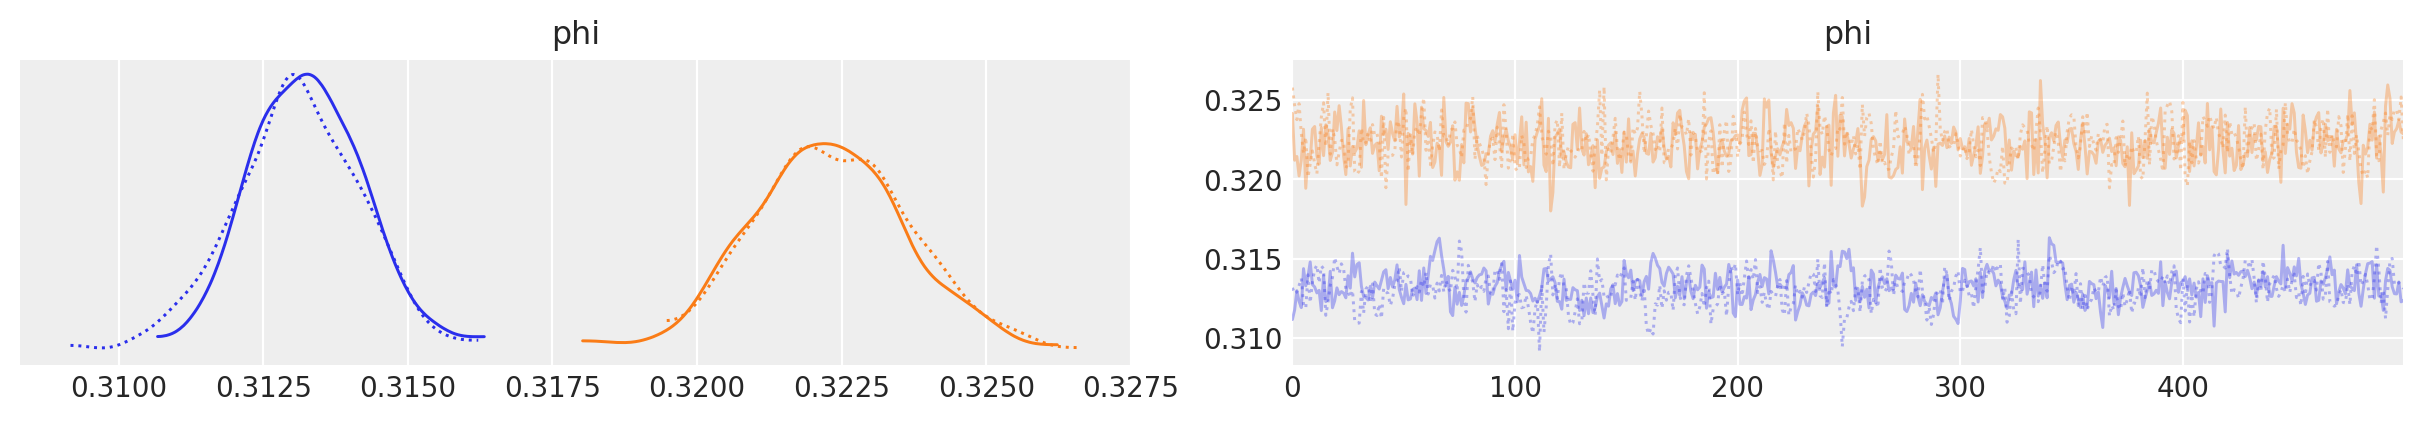

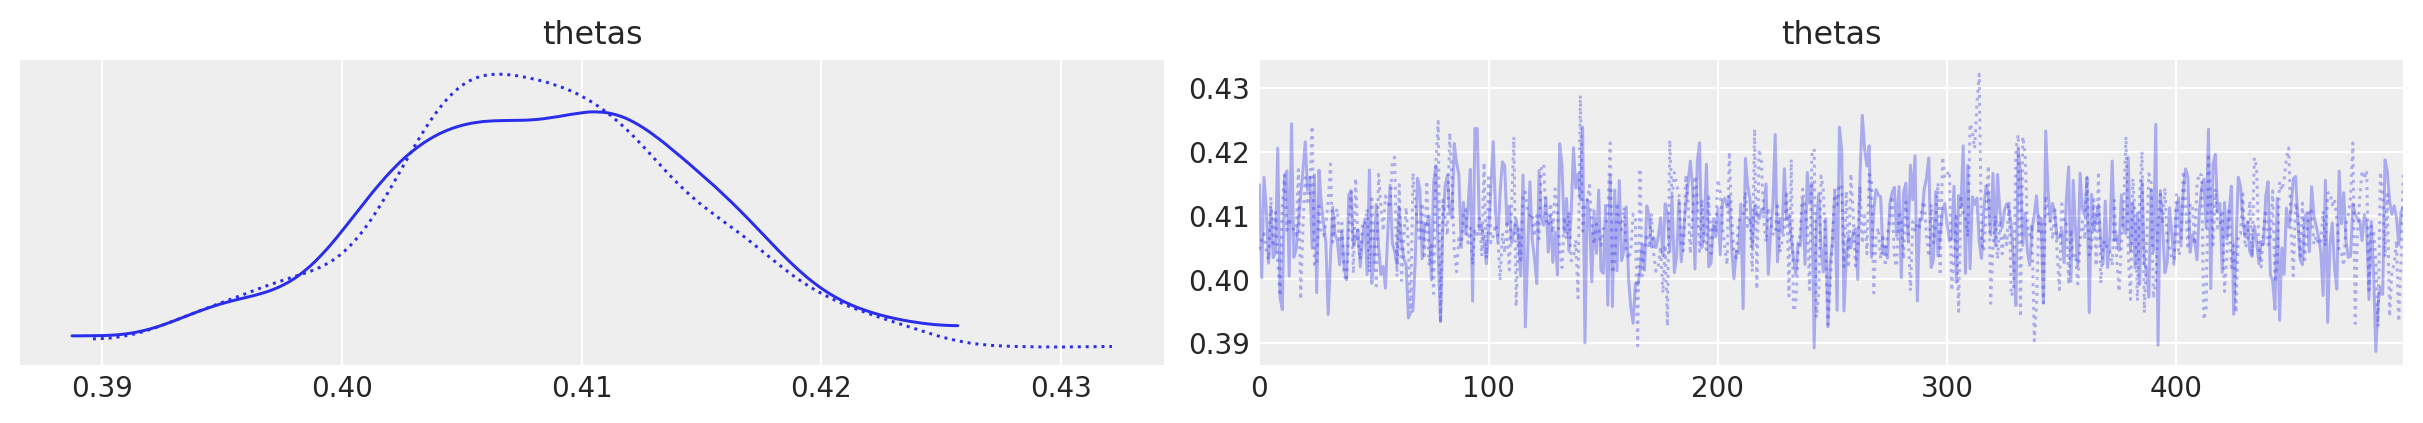

In [42]:
with OBP_model:
    az.plot_trace(OBP_trace, var_names=['phi'])
    az.plot_trace(OBP_trace, var_names=['thetas'], coords ={'thetas_dim_0':5});

# SLG Model
One way to approach slug percentage is to estimate the probability of each hit type occurring in a given at bat. We will use a multinomial model to estimate the chance of a single, double, triple, and home run in each at bat for a given batter. The hyperprior values will again be shared for all batters. The probabilities for each event will be a combination of observed skill and league tendencies.  

In [43]:
n_events = 5
n_batters = SLG_AB.shape[1]

with pm.Model() as SLG_model:
    # Hyperprior for each event
    hyper_param_comb = pm.HalfNormal('hyper_param_comb',5,shape=n_events);

    # Estimate the splits of AB results
    param_comb = pm.Dirichlet('param_comb',a=hyper_param_comb,shape=(n_batters,n_events));
    
    # Likelihood
    y_comb = pm.Multinomial('y_comb', n=SLG_AB, p=param_comb, observed=SLG_counts, shape=(n_batters,n_events));

In [44]:
# Draw 500 samples and tune on 500 more
with SLG_model:
    SLG_trace = pm.sample(draws=500,tune=500,target_accept=0.90, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [param_comb, hyper_param_comb]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 4738 seconds.


In [45]:
# Sample from posterior of SLG model to get distribution of hit types for each batter
SLG_pp = pm.sample_posterior_predictive(
      trace=SLG_trace,
      model=SLG_model,
      var_names=['param_comb'],
      progressbar=True)

The plot below show the distribution of outcomes for Bobby Abreu: singles, doubles, triples, homers, and outs, which is all we need to find his slugging percentage.

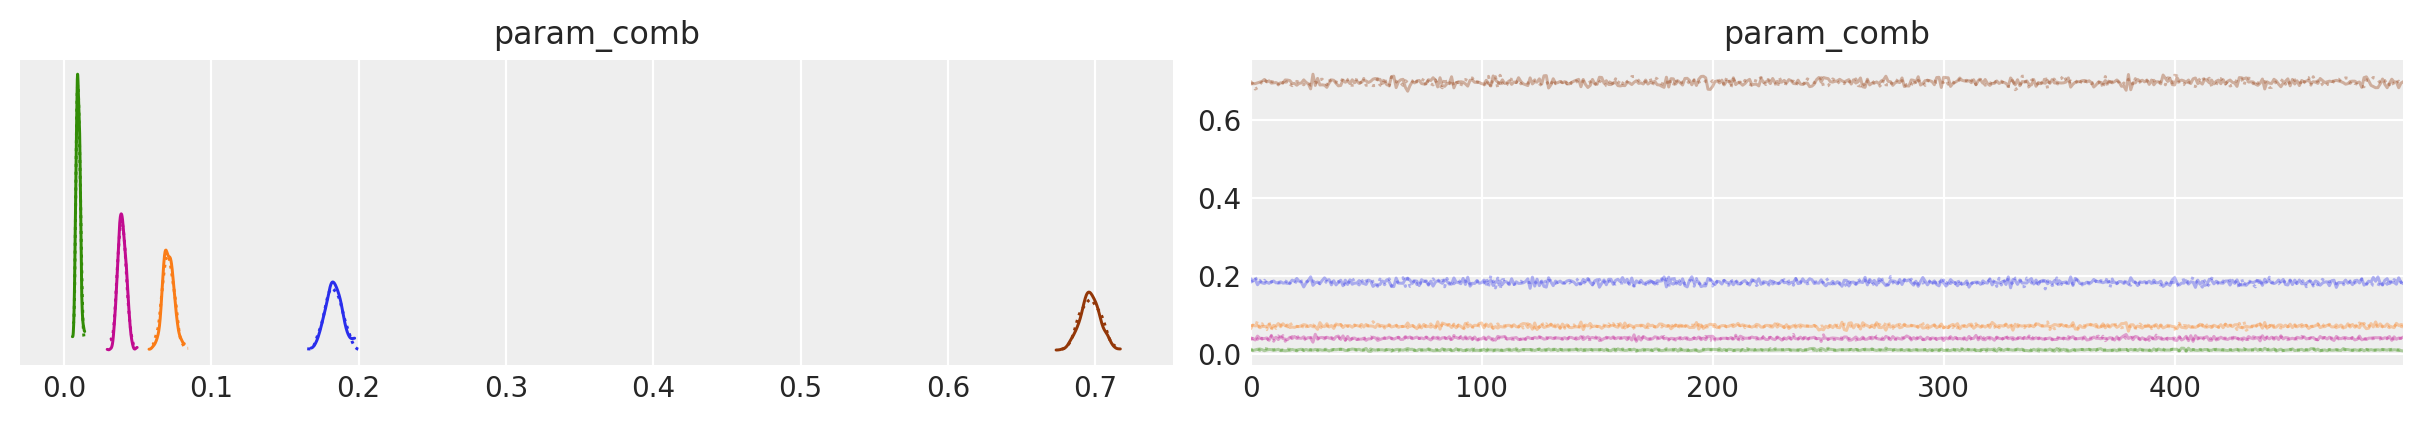

In [46]:
with SLG_model:
    az.plot_trace(SLG_trace, var_names=['param_comb'], coords ={'param_comb_dim_0':5});

# Putting it all together
We can finally combine the PA, defensive RAA, OBP and SLG models to calculate RAR. The posterior distributions for all four statistics will be taken as baselines for prospects posted in Baseball America's top 10 list at some point in their career Recall the baseline for those particular hitters are found in years prior to their age 27 season.

In [47]:
# Function to calculate RAR
def rar_calculator(age, prospect_list, PA_raa_, OBP_, SLG_):
    """age: the age to start making predictions on up to 30
    prospect_list: a list of prospect playerIDs to make forecasts for 
    PA_raa_: the outputs from the PA and RAA model
    OBP_: outputs from OBP model
    SLG_: outputs from SLG model"""
    #empty dataframe we will fill in
    forecast_df = pd.DataFrame(columns=['playerID', 'age', 'pred_RAR', 'real_RAR'])
    forecast_df.reset_index(drop=True, inplace=True)
    # Number of years to forecast
    years = 31-age
    start_age = age
    # Minimum age of each batter in dataset
    min_age = batting_final[['playerID','yearID','age']].groupby('playerID', as_index=False).min()
    for i in range(len(prospect_list)):
        # Line things up to find league average OPS for every season of interest 
        player_min_age = min_age.loc[min_age['playerID']==prospect_list[i]][['playerID','age']] \
            .groupby('playerID').min().values[0].item()
        years_over = player_min_age-18
        player_min_year = min_age.loc[min_age['playerID']==prospect_list[i]][['playerID','yearID']] \
            .groupby('playerID').min().values[0].item()
        year_at_eighteen = player_min_year-years_over
        # All information from 18 to 30 seasons; some seasons have no batter data
        player_df = pd.DataFrame({'playerID': [prospect_list[i]]*13,
                                  'yearID': list(range(year_at_eighteen,year_at_eighteen+13)),
                                  'age': list(range(18,31))})
        player_df2 = player_df.merge(pa_batter[['yearID','avg_OPS']], on='yearID', how='left')
        player_df3 = player_df.merge(older[['playerID','yearID','PA','raa_total','OPS']], on=['playerID','yearID'], how='left')
        
        age_ = start_age
        prospect = prospect_list[i]
        # Calculate RAA, PA, OBP and SLG
        def_RAA = PA_raa_['a_batter'][:,batter_lookup[prospect]]           
        PA_est = PA_raa_['lambda_prior_PA'][:,batter_lookup[prospect]]
        OBP_est_true = OBP_['thetas'][:,batter_lookup[prospect]]
        SLG_est_true = SLG_['param_comb'][:,batter_lookup[prospect],0] + 2*SLG_['param_comb'][:,batter_lookup[prospect],1] \
                       + 3*SLG_['param_comb'][:,batter_lookup[prospect],2] + 4*SLG_['param_comb'][:,batter_lookup[prospect],3]
        
        # Loop through up to age 30
        while age_ < 31:
            avg_OPS = player_df2.loc[(player_df2['age']==age_),'avg_OPS'].values[0]
            # Multipliers
            OBP_mult = scales.loc[scales['age']==age_, 'OBP'].values[0]
            SLG_mult = scales.loc[scales['age']==age_, 'SLG'].values[0]
            PA_mult = scales.loc[scales['age']==age_, 'PA'].values[0]
            
            # Offensive RAA
            off_RAA = (PA_mult * PA_est * ((OBP_mult * OBP_est_true + SLG_mult * SLG_est_true)-avg_OPS))/3.2135
            # Add it up to find RAR for that season
            RAR = def_RAA.mean() + off_RAA.mean() + 20.0
            
            # Add up real data
            real_def = player_df3.loc[(player_df3['playerID']==prospect_list[i])&(player_df3['age']==age_),'raa_total'].values[0].item()
            real_PA = player_df3.loc[(player_df3['playerID']==prospect_list[i])&(player_df3['age']==age_),'PA'].values[0].item()
            real_OPS = player_df3.loc[(player_df3['playerID']==prospect_list[i])&(player_df3['age']==age_),'OPS'].values[0].item()
            real_RAR = real_def + (real_PA*(real_OPS-avg_OPS))/3.2135 + 20

            new_row = pd.DataFrame({'playerID':[prospect_list[i]], 'age':[age_], 'pred_RAR':[RAR], 'real_RAR':[real_RAR]})
            new_row.reset_index(drop=True, inplace=True)
            forecast_df = pd.concat([forecast_df, new_row], ignore_index=True)
            age_ = age_+1
            
    return forecast_df
        


In [48]:
results = rar_calculator(27, top_ten_pros, ppc, OBP_pp, SLG_pp)

In [49]:
results['RAR_diff'] = results['real_RAR']-results['pred_RAR']

In [50]:
# Force all negative RAR values to 0 
results[results['pred_RAR']<0] = 0
results[results['real_RAR']<0] = 0

In [52]:
# Drop years without any data because the player didn't play or the data is not available
results.dropna().groupby('playerID',as_index=False).sum().sort_values('RAR_diff').head(10)

,playerID,age,pred_RAR,real_RAR,RAR_diff
55,ramirha01,114,272.217740,149.011809,-123.205932
23,garcino01,114,267.045401,158.681500,-108.363901
18,erstada01,114,114.668922,33.599787,-81.069135
44,longoev01,114,219.000492,139.150241,-79.850251
12,chaveer01,114,166.912713,89.724410,-77.188302
19,fieldpr01,114,240.620681,165.102495,-75.518187
46,mauerjo01,114,230.555481,158.360844,-72.194637
63,sizemgr01,55,97.504149,30.360655,-67.143494
9,bruceja01,114,138.131039,71.167360,-66.963679
59,riosal01,114,108.402526,59.976013,-48.426514


# Underperformers
Hanley Ramirez underperformed the most relative to forecast. In his age 27 to 30 seasons we predicted about 27 WAR, while he actually produced about 15, as can be seen in the table above. Other notable top 10 Baseball America prospects that failed to produce at levels close to their pre-age 27 seasons can also be seen.  